# Offshore CIOPS Quantitative Runs

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

## summer 2017

In [3]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')

In [4]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
mon_len = [30, 31, 30, 31, 31, 30]
h = 3601
sum_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
sum_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [5]:
meander = 0
init = 1
Nshelf = 2
Nslope = 5
Sshelf = 6
Sslope = 4
offshore = 3
sections = [Nshelf, Nslope, Sshelf, Sslope, offshore]
sec_name = ['north\nshelf', 'north\nslope', 'south\nshelf', 'south\nslope', 'offshore']

In [6]:
apr = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[0]) & (data.init_t <= sum_end[0])])/(sum_end[0]-sum_start[0]+1) for sec in sections]
may = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[1]) & (data.init_t <= sum_end[1])])/(sum_end[1]-sum_start[1]+1) for sec in sections]
jun = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[2]) & (data.init_t <= sum_end[2])])/(sum_end[2]-sum_start[2]+1) for sec in sections]
jul = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[3]) & (data.init_t <= sum_end[3])])/(sum_end[3]-sum_start[3]+1) for sec in sections]
aug = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[4]) & (data.init_t <= sum_end[4])])/(sum_end[4]-sum_start[4]+1) for sec in sections]
sep = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= sum_start[5]) & (data.init_t <= sum_end[5])])/(sum_end[5]-sum_start[5]+1) for sec in sections]

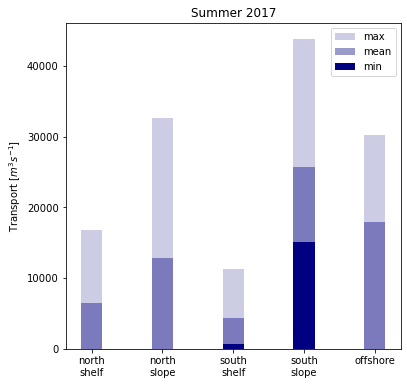

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

y = [apr, may, jun, jul, aug, sep]
x = [1,2,3,4,5,6]

mean = np.mean(y,axis=0)
mini = np.min(y,axis=0)
maxi = np.max(y,axis=0)

ax.bar(sec_name,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax.bar(sec_name,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax.bar(sec_name, mini,width = 0.3, color='navy',label='min')

ax.set_title('Summer 2017')
ax.set_ylabel('Transport [$m^{3}s^{-1}$]')
# ax.set_xlabel('Salinity [$g kg^{-1}$]')
# ax.set_ylim([0,42000])
ax.legend()

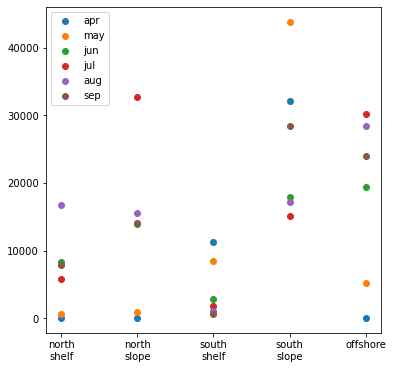

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(sec_name, apr, label='apr')
ax.scatter(sec_name, may, label='may')
ax.scatter(sec_name, jun, label='jun')
ax.scatter(sec_name, jul, label='jul')
ax.scatter(sec_name, aug, label='aug')
ax.scatter(sec_name, sep, label='sep')
ax.legend(loc='upper left')

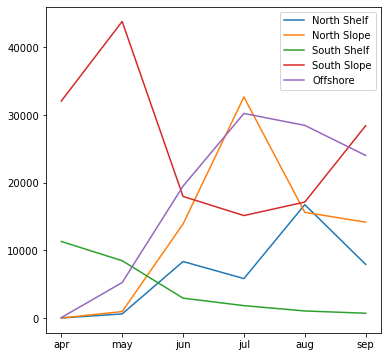

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.plot(mon, [apr[0], may[0], jun[0], jul[0], aug[0], sep[0]], label='North Shelf')
ax.plot(mon, [apr[1], may[1], jun[1], jul[1], aug[1], sep[1]], label='North Slope')
ax.plot(mon, [apr[2], may[2], jun[2], jul[2], aug[2], sep[2]], label='South Shelf')
ax.plot(mon, [apr[3], may[3], jun[3], jul[3], aug[3], sep[3]], label='South Slope')
ax.plot(mon, [apr[4], may[4], jun[4], jul[4], aug[4], sep[4]], label='Offshore')
ax.legend(loc='upper right')

## winter 2017/18

In [10]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')

In [11]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [12]:
octo = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[0]) & (data.init_t <= win_end[0])])/(win_end[0]-win_start[0]+1) for sec in sections]
nov = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[1]) & (data.init_t <= win_end[1])])/(win_end[1]-win_start[1]+1) for sec in sections]
dec = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[2]) & (data.init_t <= win_end[2])])/(win_end[2]-win_start[2]+1) for sec in sections]
jan = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[3]) & (data.init_t <= win_end[3])])/(win_end[3]-win_start[3]+1) for sec in sections]
feb = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[4]) & (data.init_t <= win_end[4])])/(win_end[4]-win_start[4]+1) for sec in sections]
mar = [np.sum(data.final_transp[(data.final_section==sec) & (data.init_t >= win_start[5]) & (data.init_t <= win_end[5])])/(win_end[5]-win_start[5]+1) for sec in sections]

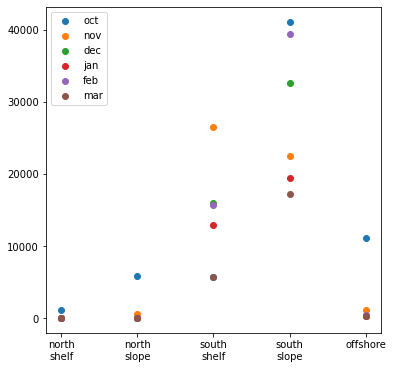

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(sec_name, octo, label='oct')
ax.scatter(sec_name, nov, label='nov')
ax.scatter(sec_name, dec, label='dec')
ax.scatter(sec_name, jan, label='jan')
ax.scatter(sec_name, feb, label='feb')
ax.scatter(sec_name, mar, label='mar')
ax.legend(loc='upper left')

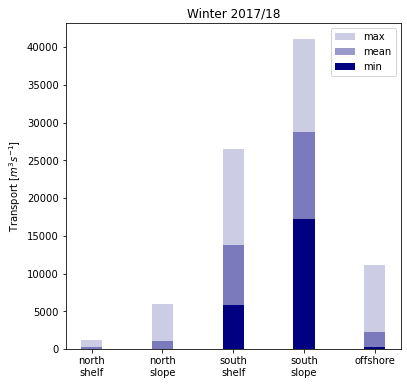

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

y = [octo, nov, dec, jan, feb, mar]
x = [1,2,3,4,5,6]

mean = np.mean(y,axis=0)
mini = np.min(y,axis=0)
maxi = np.max(y,axis=0)

ax.bar(sec_name,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax.bar(sec_name,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax.bar(sec_name, mini,width = 0.3, color='navy',label='min')

ax.set_title('Winter 2017/18')
ax.set_ylabel('Transport [$m^{3}s^{-1}$]')
# ax.set_xlabel('Salinity [$g kg^{-1}$]')
# ax.set_ylim([0,42000])
ax.legend()

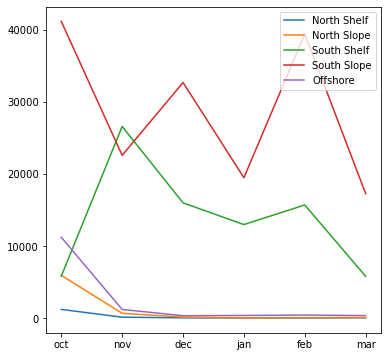

In [15]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.plot(mon, [octo[0], nov[0], dec[0], jan[0], feb[0], mar[0]], label='North Shelf')
ax.plot(mon, [octo[1], nov[1], dec[1], jan[1], feb[1], mar[1]], label='North Slope')
ax.plot(mon, [octo[2], nov[2], dec[2], jan[2], feb[2], mar[2]], label='South Shelf')
ax.plot(mon, [octo[3], nov[3], dec[3], jan[3], feb[3], mar[3]], label='South Slope')
ax.plot(mon, [octo[4], nov[4], dec[4], jan[4], feb[4], mar[4]], label='Offshore')
ax.legend(loc='upper right')

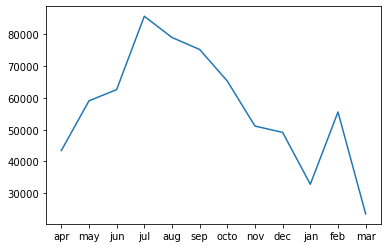

In [16]:
# total transport
plt.plot(['apr','may','jun','jul','aug','sep','octo','nov','dec','jan','feb','mar'],[sum(apr),sum(may),sum(jun),sum(jul),sum(aug),sum(sep),sum(octo),sum(nov),sum(dec),sum(jan),sum(feb),sum(mar)])

In [17]:
# NEXT - transport weighted histograms of the tracers

In [18]:
Sdata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')

Fapr = (Sdata.final_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[0]) & (Sdata.init_t <= sum_end[0])])/(sum_end[0]-sum_start[0]+1)
Fmay = (Sdata.final_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[1]) & (Sdata.init_t <= sum_end[1])])/(sum_end[1]-sum_start[1]+1)
Fjun = (Sdata.final_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[2]) & (Sdata.init_t <= sum_end[2])])/(sum_end[2]-sum_start[2]+1)
Fjul = (Sdata.final_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[3]) & (Sdata.init_t <= sum_end[3])])/(sum_end[3]-sum_start[3]+1)
Faug = (Sdata.final_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[4]) & (Sdata.init_t <= sum_end[4])])/(sum_end[4]-sum_start[4]+1)
Fsep = (Sdata.final_transp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[5]) & (Sdata.init_t <= sum_end[5])])/(sum_end[5]-sum_start[5]+1)

Sapr = (Sdata.final_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[0]) & (Sdata.init_t <= sum_end[0])])
Smay = (Sdata.final_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[1]) & (Sdata.init_t <= sum_end[1])])
Sjun = (Sdata.final_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[2]) & (Sdata.init_t <= sum_end[2])])
Sjul = (Sdata.final_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[3]) & (Sdata.init_t <= sum_end[3])])
Saug = (Sdata.final_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[4]) & (Sdata.init_t <= sum_end[4])])
Ssep = (Sdata.final_salt[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[5]) & (Sdata.init_t <= sum_end[5])])

Tapr = (Sdata.final_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[0]) & (Sdata.init_t <= sum_end[0])])
Tmay = (Sdata.final_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[1]) & (Sdata.init_t <= sum_end[1])])
Tjun = (Sdata.final_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[2]) & (Sdata.init_t <= sum_end[2])])
Tjul = (Sdata.final_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[3]) & (Sdata.init_t <= sum_end[3])])
Taug = (Sdata.final_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[4]) & (Sdata.init_t <= sum_end[4])])
Tsep = (Sdata.final_temp[(Sdata.final_section != 0) & (Sdata.init_t >= sum_start[5]) & (Sdata.init_t <= sum_end[5])])

In [20]:
Wdata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')

Foct = (Wdata.final_transp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[0]) & (Wdata.init_t <= win_end[0])])/(win_end[0]-win_start[0]+1)
Fnov = (Wdata.final_transp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[1]) & (Wdata.init_t <= win_end[1])])/(win_end[1]-win_start[1]+1)
Fdec = (Wdata.final_transp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[2]) & (Wdata.init_t <= win_end[2])])/(win_end[2]-win_start[2]+1)
Fjan = (Wdata.final_transp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[3]) & (Wdata.init_t <= win_end[3])])/(win_end[3]-win_start[3]+1)
Ffeb = (Wdata.final_transp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[4]) & (Wdata.init_t <= win_end[4])])/(win_end[4]-win_start[4]+1)
Fmar = (Wdata.final_transp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[5]) & (Wdata.init_t <= win_end[5])])/(win_end[5]-win_start[5]+1)

Soct = (Wdata.final_salt[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[0]) & (Wdata.init_t <= win_end[0])])
Snov = (Wdata.final_salt[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[1]) & (Wdata.init_t <= win_end[1])])
Sdec = (Wdata.final_salt[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[2]) & (Wdata.init_t <= win_end[2])])
Sjan = (Wdata.final_salt[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[3]) & (Wdata.init_t <= win_end[3])])
Sfeb = (Wdata.final_salt[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[4]) & (Wdata.init_t <= win_end[4])])
Smar = (Wdata.final_salt[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[5]) & (Wdata.init_t <= win_end[5])])

Toct = (Wdata.final_temp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[0]) & (data.init_t <= win_end[0])])
Tnov = (Wdata.final_temp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[1]) & (data.init_t <= win_end[1])])
Tdec = (Wdata.final_temp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[2]) & (data.init_t <= win_end[2])])
Tjan = (Wdata.final_temp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[3]) & (data.init_t <= win_end[3])])
Tfeb = (Wdata.final_temp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[4]) & (data.init_t <= win_end[4])])
Tmar = (Wdata.final_temp[(Wdata.final_section != 0) & (Wdata.init_t >= win_start[5]) & (data.init_t <= win_end[5])])

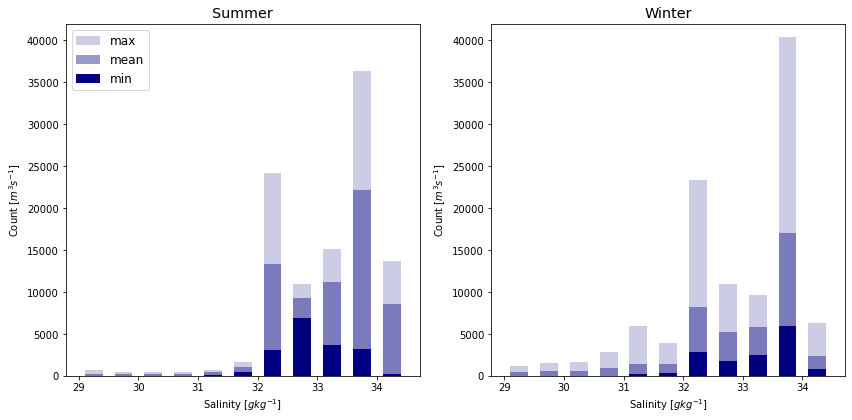

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
plt.rcParams['font.size'] = 12
#plt summer
sum_sal,x,_ = ax[0].hist([Sapr, Smay, Sjun, Sjul, Saug, Ssep], bins=np.arange(29,35,0.5), weights= [Fapr, Fmay, Fjun, Fjul, Faug, Fsep],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(sum_sal,axis=0)
mini = np.min(sum_sal,axis=0)
maxi = np.max(sum_sal,axis=0)

ax[0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0].set_title('Summer')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_xlabel('Salinity [$g kg^{-1}$]')
ax[0].set_ylim([0,42000])
ax[0].legend()

#plt winter
win_sal,x,_ = ax[1].hist([Soct, Snov, Sdec, Sjan, Sfeb, Smar], bins=np.arange(29,35,0.5), weights= [Foct, Fnov, Fdec, Fjan, Ffeb, Fmar],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(win_sal,axis=0)
mini = np.min(win_sal,axis=0)
maxi = np.max(win_sal,axis=0)

ax[1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[1].set_title('Winter')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_xlabel('Salinity [$g kg^{-1}$]')
ax[1].set_ylim([0,42000])
# ax[1].legend()

plt.tight_layout()

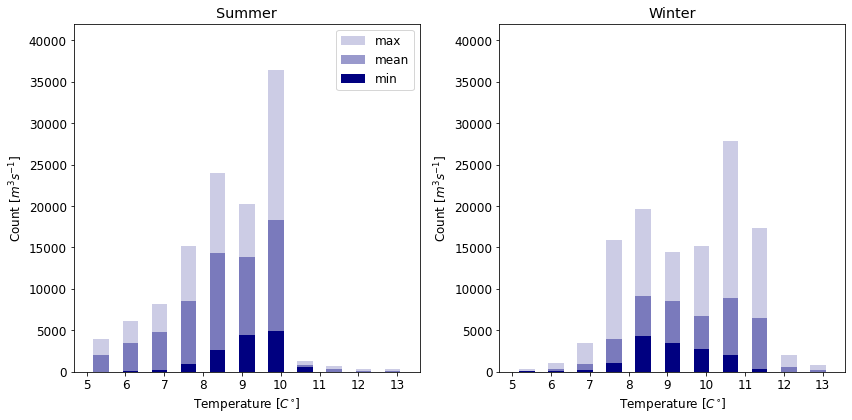

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
plt.rcParams['font.size'] = 12
#plt summer
sum_tem,x,_ = ax[0].hist([Tapr, Tmay, Tjun, Tjul, Taug, Tsep], bins=np.arange(5,14,0.75), weights= [Fapr, Fmay, Fjun, Fjul, Faug, Fsep],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(sum_tem,axis=0)
mini = np.min(sum_tem,axis=0)
maxi = np.max(sum_tem,axis=0)

ax[0].bar(bin_centers,maxi,width = 0.4,color='navy',alpha=0.2,label='max')
ax[0].bar(bin_centers,mean,width = 0.4, color='navy',alpha=0.4,label='mean')
ax[0].bar(bin_centers, mini,width = 0.4, color='navy',label='min')

ax[0].set_title('Summer')
ax[0].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[0].set_xlabel('Temperature [$C^{\circ}$]')
ax[0].set_ylim([0,42000])
ax[0].legend()

#plt winter
win_tem,x,_ = ax[1].hist([Toct, Tnov, Tdec, Tjan, Tfeb, Tmar], bins=np.arange(5,14,0.75), weights= [Foct, Fnov, Fdec, Fjan, Ffeb, Fmar],alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(win_tem,axis=0)
mini = np.min(win_tem,axis=0)
maxi = np.max(win_tem,axis=0)

ax[1].bar(bin_centers,maxi,width = 0.4,color='navy',alpha=0.2,label='max')
ax[1].bar(bin_centers,mean,width = 0.4, color='navy',alpha=0.4,label='mean')
ax[1].bar(bin_centers, mini,width = 0.4, color='navy',label='min')

ax[1].set_title('Winter')
ax[1].set_ylabel('Count [$m^{3}s^{-1}$]')
ax[1].set_xlabel('Temperature [$C^{\circ}$]')
ax[1].set_ylim([0,42000])
# ax[1].legend()

plt.tight_layout()

# Cross sections of flow 

In [28]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(len(t_depths)-1):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

In [80]:
def FluxEW(mydata, tracername, section, lonW, lonE, fjgrid, maxdepth, ax, title):
    igrid = fjgrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[lonW-1:lonE+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    if len(section) >1:
        lons = mydata.final_lon[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
        dist = lons/m2lon
        depths = depthf(mydata.final_z[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]-1.)[0]
        transports = mydata.final_transp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]/time
        
        H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= transports, density= True)
        _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
        if tracername == 'trans':
            t_max = (0.01/np.sum(transports)).values
            tick = np.round(((t_max*sum(transports)).values),2)
            cmap = cm.speed
            units = '$m s^{-1}$'
            
            H_final = H1.T
    
        elif tracername == 'temp' or tracername == 'salt':
            if tracername == 'temp':
                tracer = mydata.init_temp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
                t_max = round(1 * 0.1,1)
                tick = t_max
                cmap = cm.rain
                units = '$C^{\circ} m s^{-1}$'
            else:
                tracer = mydata.init_salt[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
                t_max = round(15 * 0.1,1)
                tick = t_max
                cmap = cm.amp
                units = '$g kg^{-1} m s^{-1}$'
        
            H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
            H_final = H1.T * H.statistic.T * float(sum(transports))
    
        else:
            print('incorrect tracer name, options are trans, salt, temp')
            
    else:
        lons = mydata.final_lon[(mydata.final_section==section)]
        dist = lons/m2lon
        depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
        transports = mydata.final_transp[(mydata.final_section==section)]/time
        
        H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= transports, density= True)
        _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
        if tracername == 'trans':
            t_max = (0.01/np.sum(transports)).values
            tick = np.round(((t_max*sum(transports)).values),2)
            cmap = cm.speed
            units = '$m s^{-1}$'
            
            H_final = H1.T
    
        elif tracername == 'temp' or tracername == 'salt':
            if tracername == 'temp':
                tracer = mydata.init_temp[(mydata.final_section == section)]
                t_max = round(1 * 0.1,1)
                tick = t_max
                cmap = cm.rain
                units = '$C^{\circ} m s^{-1}$'
            else:
                tracer = mydata.init_salt[(mydata.final_section == section)]
                t_max = round(15 * 0.1,1)
                tick = t_max
                cmap = cm.amp
                units = '$g kg^{-1} m s^{-1}$'
        
            H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths])
            H_final = H1.T * H.statistic.T * float(sum(transports))
    
        else:
            print('incorrect tracer name, options are trans, salt, temp')

    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW], t_dist[lonE], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW], t_lons[lonE], 5),2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE-1]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')
    mydata.close()
    
    return t_dist

In [76]:
def FluxNS(mydata, tracername, section, latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    lats = mydata.final_lat[(mydata.final_section==section)]
    dist = lats/m2lat
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
    if tracername == 'trans':
        t_max = (0.01/np.sum(transports)).values
        tick = np.round(((t_max*sum(transports)).values),2)
        cmap = cm.speed
        units = '$m s^{-1}$'
        
        H_final = H1.T
    
    elif tracername == 'temp' or tracername == 'salt':
        if tracername == 'temp':
            tracer = mydata.init_temp[(mydata.final_section == section)]
            t_max = round(1 * 0.1,1)
            tick = t_max
            cmap = cm.rain
            units = '$C^{\circ} m s^{-1}$'
        else:
            tracer = mydata.init_salt[(mydata.final_section == section)]
            t_max = round(15 * 0.1,1)
            tick = t_max
            cmap = cm.amp
            units = '$g kg^{-1} m s^{-1}$'
        
        H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
        H_final = H1.T * H.statistic.T * float(sum(transports))
    
    else:
        print('incorrect tracer name, options are trans, salt, temp')
    
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick])
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')
    mydata.close()

In [25]:
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [26]:
#in the format [section, igridW, igridE, fjgrid, maxdepth] for horizontal CS
# OR for vertical [section, jgridS, jgridN, figrid, maxdepth]
init = [1,259, 274, 640,250] #v
Nshelf = [2, 545, 585, 321, 180] #h
Nslope = [5, 531, 544, 321,500] #h
Sshelf = [6, 629, 644, 200, 180] #h
Sslope = [4, 579, 628, 200, 1500] #h
offshore = [3, 199, 300, 560, 3000] # v

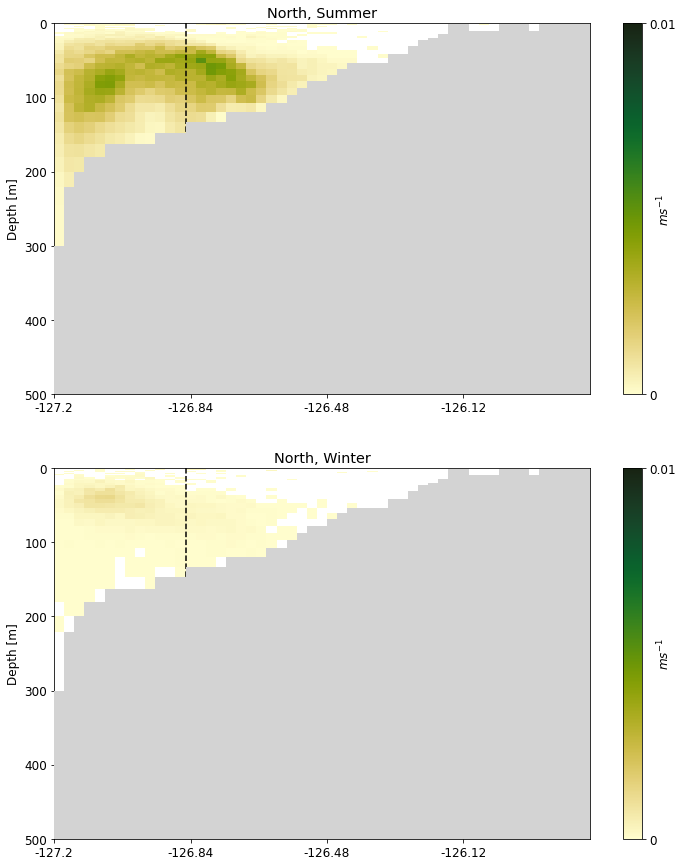

In [83]:
fig, ax = plt.subplots(2,1, figsize=[12,15])
t_dist = FluxEW(Sdata, 'trans', [Nslope[0], Nshelf[0]], Nslope[1], Nshelf[2], Nslope[3], Nslope[4], ax[0], 'North, Summer')
ax[0].plot([t_dist[544],t_dist[544]], [0,500], 'k--', zorder=2)

t_dist = FluxEW(Wdata, 'trans', [Nslope[0], Nshelf[0]], Nslope[1], Nshelf[2], Nslope[3], Nslope[4], ax[1], 'North, Winter')
ax[1].plot([t_dist[544],t_dist[544]], [0,500], 'k--', zorder=2)

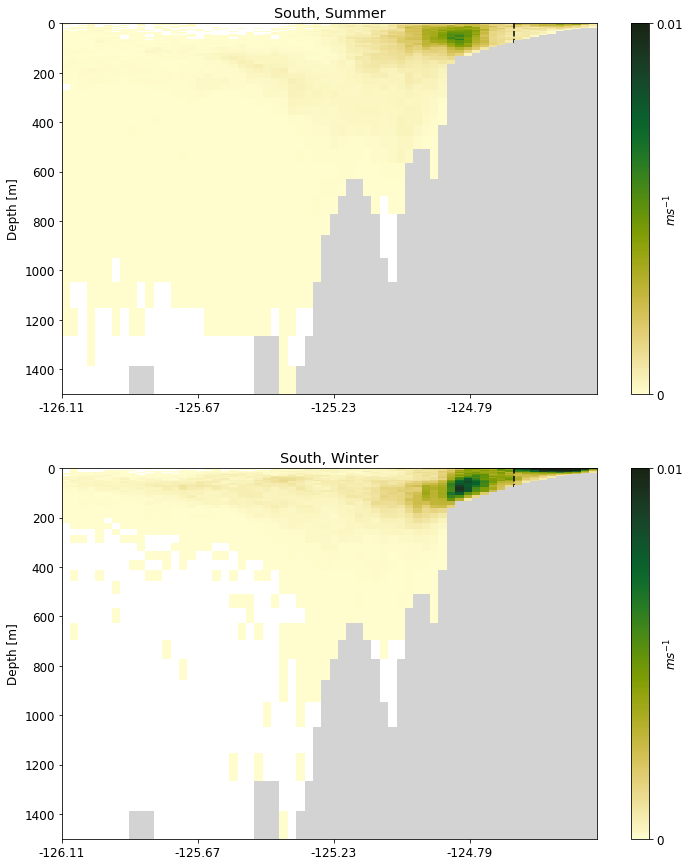

In [82]:
fig, ax = plt.subplots(2,1, figsize=[12,15])
t_dist = FluxEW(Sdata, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], ax[0], 'South, Summer')
ax[0].plot([t_dist[633],t_dist[633]], [0,500], 'k--', zorder=2)

t_dist = FluxEW(Wdata, 'trans', [Sslope[0], Sshelf[0]], Sslope[1], Sshelf[2], Sslope[3], Sslope[4], ax[1], 'South, Winter')
ax[1].plot([t_dist[633],t_dist[633]], [0,500], 'k--', zorder=2)

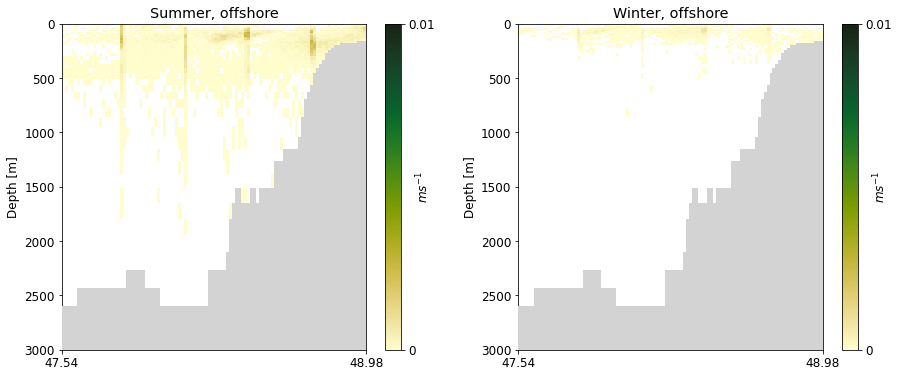

In [84]:
fig, ax = plt.subplots(1,2, figsize=[15,6])
FluxNS(Sdata, 'trans', offshore[0], offshore[1], offshore[2], offshore[3], offshore[4], ax[0], 'Summer, offshore')
FluxNS(Wdata, 'trans', offshore[0], offshore[1], offshore[2], offshore[3], offshore[4], ax[1], 'Winter, offshore')

In [59]:
def JRFluxNS(mydata, tracername,latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    lats = mydata.init_lat[(mydata.final_section != 0)]
    dist = lats/m2lat
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
    if tracername == 'trans':
        t_max = (0.05/np.sum(transports)).values
        tick = np.round(((t_max*sum(transports)).values),2)
        cmap = cm.speed
        units = '$m s^{-1}$'
        
        H_final = H1.T
    
    elif tracername == 'temp' or tracername == 'salt':
        if tracername == 'temp':
            tracer = mydata.init_temp[(mydata.final_section != 0)]
            t_max = round(1 * 0.1,1)
            tick = t_max
            cmap = cm.rain
            units = '$C^{\circ} m s^{-1}$'
        else:
            tracer = mydata.init_salt[(mydata.final_section != 0)]
            t_max = round(15 * 0.1,1)
            tick = t_max
            cmap = cm.amp
            units = '$g kg^{-1} m s^{-1}$'
        
        H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
        H_final = H1.T * H.statistic.T * float(sum(transports))
    
    else:
        print('incorrect tracer name, options are trans, salt, temp')
    
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick])
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')
    mydata.close()

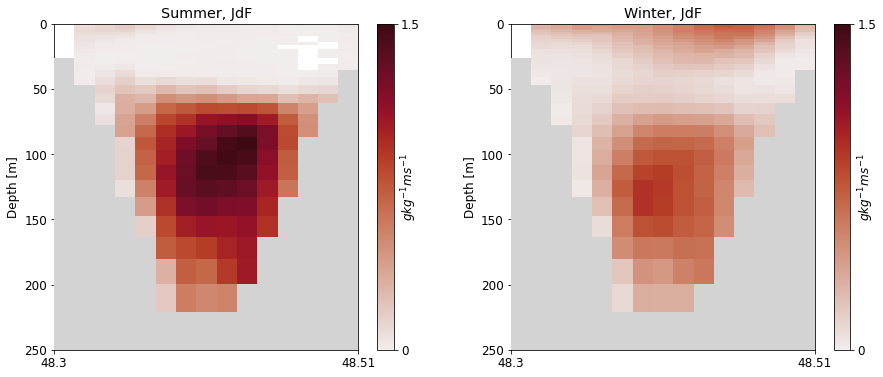

In [45]:
fig, ax = plt.subplots(1,2, figsize=[15,6])
JRFluxNS(Sdata, 'salt', init[1], init[2], init[3], init[4], ax[0], 'Summer, JdF')
JRFluxNS(Wdata, 'salt', init[1], init[2], init[3], init[4], ax[1], 'Winter, JdF')

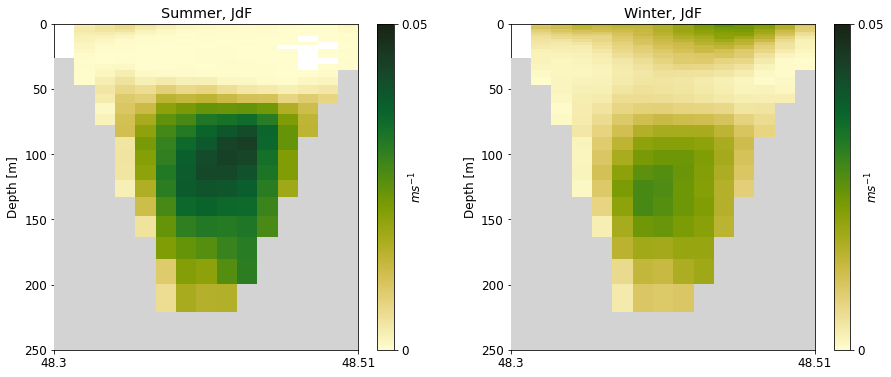

In [60]:
fig, ax = plt.subplots(1,2, figsize=[15,6])
JRFluxNS(Sdata, 'trans', init[1], init[2], init[3], init[4], ax[0], 'Summer, JdF')
JRFluxNS(Wdata, 'trans', init[1], init[2], init[3], init[4], ax[1], 'Winter, JdF')